In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from collections import defaultdict
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5 # the relative size  of legend markers vs original
plt.rcParams['legend.handletextpad'] = .5
plt.rcParams['legend.labelspacing'] = .4 # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = .5
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

# 1. Вероятность больших перекосов

In [3]:
N = 1000
n_iter = 10000

data = np.zeros(2 * N)
data[:N] = 1

res = []
sample_sizes = [10, 20, 50, 100, 500]
for sample_size in sample_sizes:
    list_part_second_strata = []
    for _ in range(n_iter):
        sample = np.random.choice(data, sample_size, False)
        list_part_second_strata.append(np.mean(sample))
    res.append(list_part_second_strata)

df_res = pd.DataFrame(res, index=sample_sizes).T

/var/folders/wt/fs62y8p10lxgyr__1q15y4_m0000gn/T/ipykernel_1857/831655756.py:2: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=df_res, bw=.2, cut=1, linewidth=1)


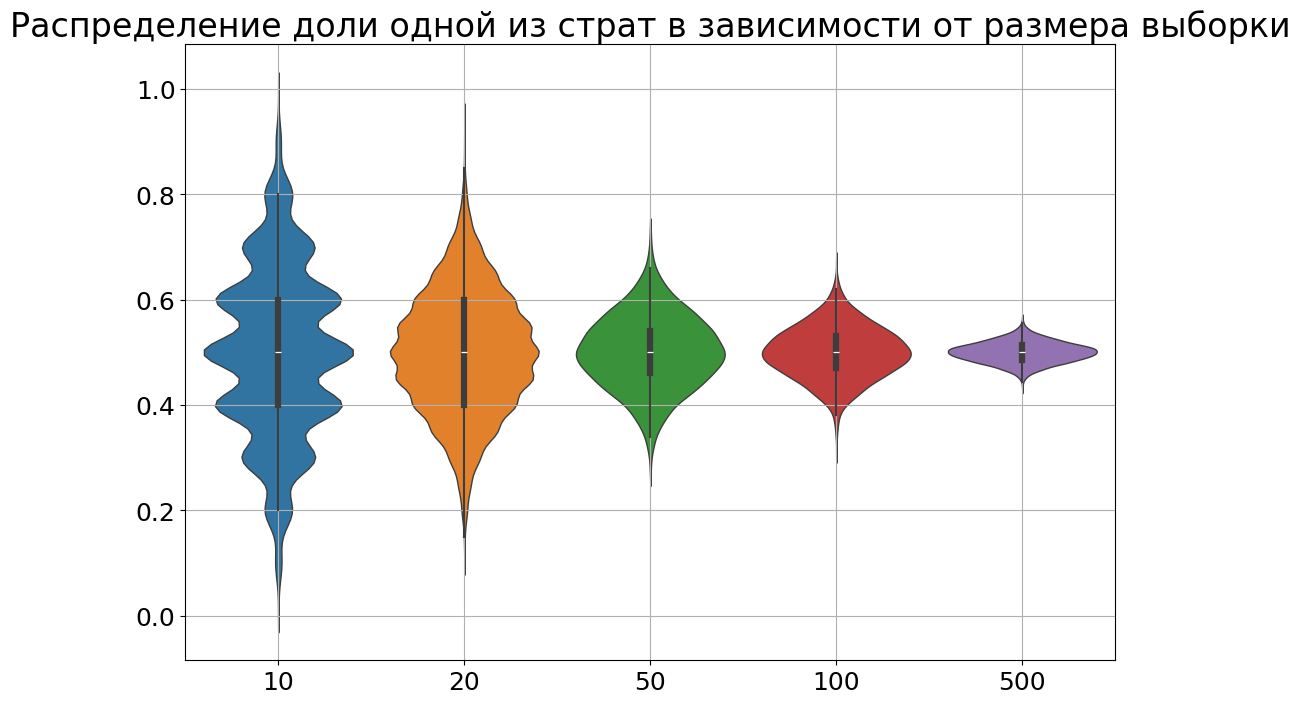

In [4]:
fig = plt.figure(figsize=[12, 8])
sns.violinplot(data=df_res, bw=.2, cut=1, linewidth=1)
plt.title('Распределение доли одной из страт в зависимости от размера выборки')
plt.grid()
plt.show()

Маленькие выборки несут заметный риск нерепрезентативности. Игогда можно такую ситуацию предотвратить на этапе
дизайна эксперемента. И заранее предусмотреть выбор репрезентативных групп. Но это возможно далеко не всегда.

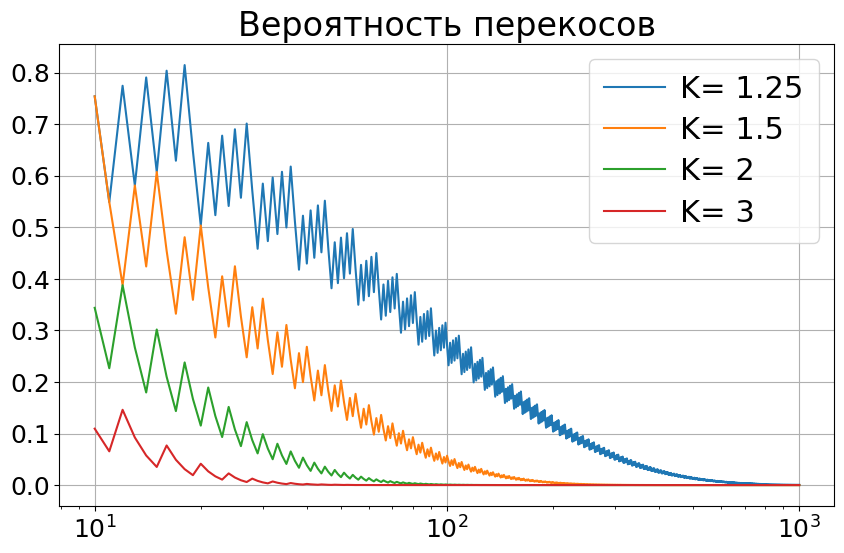

In [5]:
N = np.arange(10, 1000)
plt.title('Вероятность перекосов')
for K in [1.25, 1.5, 2, 3]:
    prob = 2 * stats.binom.cdf(N / (1 + K), N, .5)
    plt.plot(N, prob, label=f'K= {K}')
plt.xscale('log')
plt.legend()
plt.grid()

# 2. Дисперсия при стратификации

* **Случайное семплирование**
* **Стратифицированное семплирование**
* **Постстратификация** (с весами из генеральной совокупности)

In [6]:
def get_sample_mean(data, size):
    return np.random.choice(data, size, False).mean()

def calc_srs_stats(
    strata: list, 
    sample_size=100, n_iter=1000
):
    """Считаем дисперсию обычного среднего при случайном сэмплировании.
    strata - список страт
    sample_size - размер сэмплируемой выборки
    n_Iter - количество итераций сэмплирования

    return: преднее средних, дисперсия средних
    """
    data = np.concatenate(strata)
    means = [get_sample_mean(data, sample_size) for _ in range(n_iter)]

    return np.mean(means), np.var(means)

In [7]:
def calc_strat_stats(
    strata: list, 
    sample_size=100, n_iter=1000,
    is_stratified=True
):
    """Считаем дисперсию среднего значения при стратифицированном сэмплировании
    strata - список страт
    sample_size - размер сэмплируемой выборки
    n_Iter - количество итераций сэмплирования

    return: преднее средних, дисперсия средних
    """
    strata_sizes = [len(stratum) for stratum in strata]
    full_size = np.sum(strata_sizes)
    weights = np.array(strata_sizes) / full_size

    sample_sizes = np.zeros(shape=len(strata))
    if is_stratified:
        sample_sizes = (weights * sample_size + .5).astype(int)
    else:
        while (np.array(sample_sizes)).min() == 0:
            sample_sizes = np.random.default_rng().multinomial(sample_size, weights)

    assert sample_sizes.min() != 0

    means = []
    for _ in range(n_iter):
        strata_means = [get_sample_mean(stratum, size) for stratum, size in zip(strata, sample_sizes)]
        means.append((weights * np.array(strata_means)).sum())
    return np.mean(means), np.var(means)


def calc_srs_strat_stats(
    strata: list, 
    sample_size=100, n_iter=1000
):
    """Считаем дисперсию среднего стратифицированного при случайном сэмплировании.
    strata - список страт
    strata_second - множество значений второй страты
    sample_size - размер сэмплируемой выборки
    n_Iter - количество итераций сэмплирования

    return: преднее средних, дисперсия средних
    """
    return calc_strat_stats(strata, sample_size=sample_size, n_iter=n_iter, is_stratified=False)
    

In [8]:
def run_calc_vars(
    strata: list, 
    sample_size=100, n_iter=1000,
    show=False
):
    """Считаем мреднее и дисперсии средних значений, посчитанных при
    сэмплировании разными способами.
    """
    function_dict = {
        'strat': calc_strat_stats,
        'srs_strat': calc_srs_strat_stats,
        'srs': calc_srs_stats
    }
    res_dict = {}
    for function_name, function in function_dict.items():
        mean_, var_ = function(strata, sample_size, n_iter)
        res_dict[f'mean {function_name}'] = mean_
        res_dict[f'var {function_name}'] = var_
        if show:
            print(f'{function_name:<10} mean {mean_:.4f}, var {var_:.4f}')
    return res_dict

Проведем серию численных эксперементов
При одинаковых рпспределениях в стратах дисперсии должны быть одинаковы. Разница средних же обеспечивает различие в
дисперсиях.

In [9]:
np.random.seed(45)

data_for_experiments = [
    {
        'experiment_title': 'Same mean, same variance',
        'strata': [
            np.random.normal(0, 1, 100),
            np.random.normal(0, 1, 100),
        ]
    },
    {
        'experiment_title': 'Same mean, Different variance',
        'strata': [
            np.random.normal(0, 1, 100),
            np.random.normal(0, 2, 100),
        ]
    },
    {
        'experiment_title': 'Different mean, same variance',
        'strata': [
            np.random.normal(0, 1, 100),
            np.random.normal(2, 1, 100),
        ]
    },
    {
        'experiment_title': 'Different mean, Different variance',
        'strata': [
            np.random.normal(0, 1, 100),
            np.random.normal(3, 2, 100),
        ]
    }
]

sample_size = 100 
n_iter = 10000

for data in data_for_experiments:
    print(f'\n    Experiment: {data["experiment_title"]}')
    _ = run_calc_vars(data['strata'], sample_size, n_iter, show=True)




    Experiment: Same mean, same variance
strat      mean -0.0316, var 0.0046
srs_strat  mean -0.0329, var 0.0050
srs        mean -0.0309, var 0.0048

    Experiment: Same mean, Different variance
strat      mean -0.0575, var 0.0117
srs_strat  mean -0.0563, var 0.0129
srs        mean -0.0570, var 0.0123

    Experiment: Different mean, same variance
strat      mean 0.9366, var 0.0046
srs_strat  mean 0.9372, var 0.0058
srs        mean 0.9364, var 0.0103

    Experiment: Different mean, Different variance
strat      mean 1.4789, var 0.0139
srs_strat  mean 1.4782, var 0.0141
srs        mean 1.4790, var 0.0264


# Построим зависимость дисперсии оценок среднего в зависимости от размера выборки

In [10]:
def plot_mean_var(df):
    """Рисует графики средних и дисперсий по значениям в столбцах датафрейма."""
    columns = df.columns
    columns_var = [c for c in columns if 'var' in c]
    columns_mean = [c for c in columns if 'mean' in c]

    fig = plt.figure(figsize=[16, 6])
    
    ax_one = plt.subplot(121)
    df[columns_var].plot(ax=ax_one)
    ax_one.set_title('var')
    plt.grid()
    
    ax_two = plt.subplot(122)
    df[columns_mean].plot(ax=ax_two)
    ax_two.set_title('mean')
    
    ax_two.set_ylim([-.1, df[columns_mean].values.max() * 1.1])
    plt.grid()

  0%|          | 0/19 [00:00<?, ?it/s]

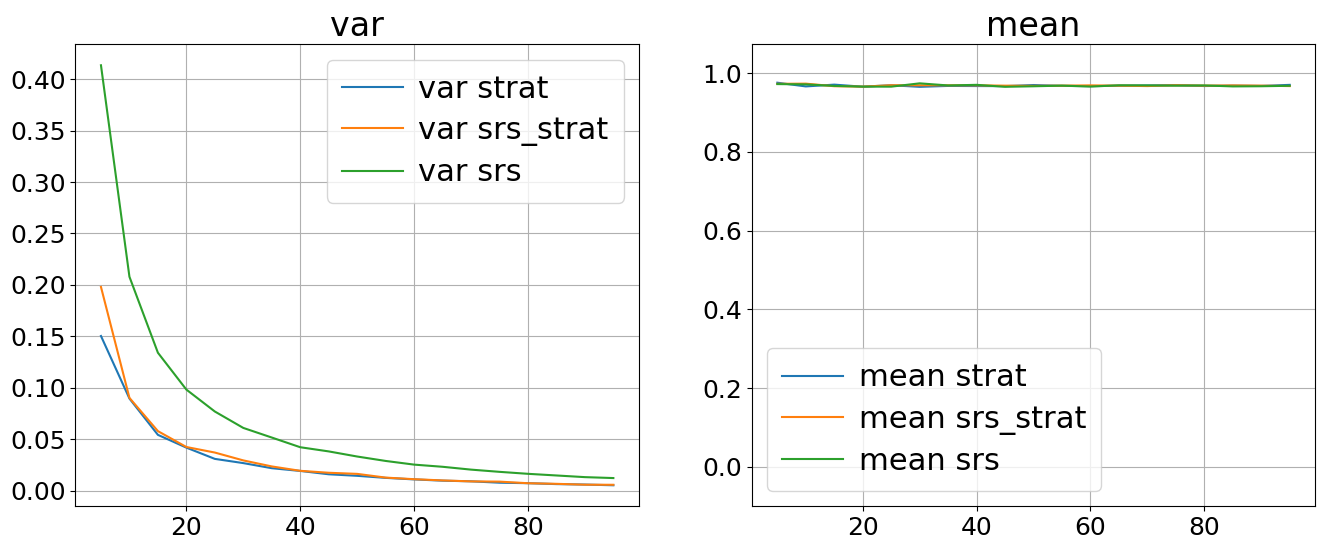

In [11]:
np.random.seed(45)

data_first = np.random.normal(0, 1, 100)
data_second = np.random.normal(2, 1, 100)

sample_sizes = np.arange(5, 100, 5)
n_iter = 10000

res = []

for sample_size in tqdm(sample_sizes):
    res.append(run_calc_vars([data_first, data_second], sample_size, n_iter, show=False))

df = pd.DataFrame(res, index=sample_sizes)
plot_mean_var(df)

Построим зависимость дисперсий от величины отличия средних между стратами

  0%|          | 0/51 [00:00<?, ?it/s]

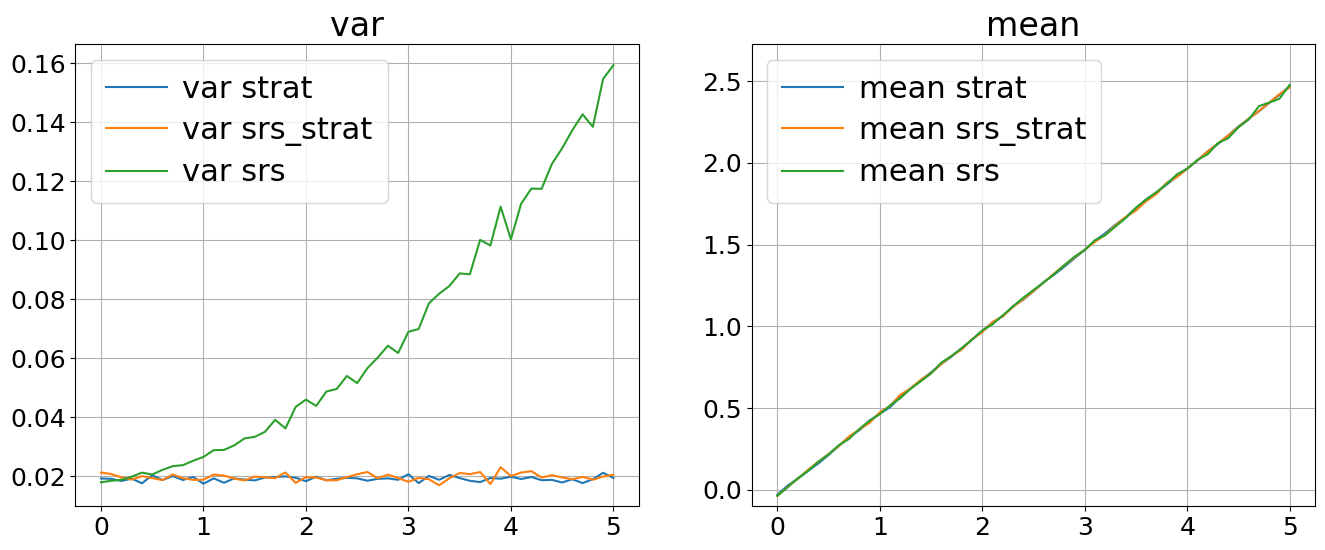

In [12]:
np.random.seed(45)
sample_size = 40
n_iter = 1000
mean_deltas = np.linspace(0, 5, 51)

data_first = np.random.normal(0, 1, 100)
data_second = np.random.normal(0, 1, 100)

res = []
for mean_delta in tqdm(mean_deltas):
    res.append(run_calc_vars([data_first, data_second + mean_delta], sample_size, n_iter, show=False))

df = pd.DataFrame(res, index=mean_deltas)
plot_mean_var(df)

При увеличении отличий между стратами дисперсии strat и srs_strat практически не изменяются, а дисперсия srs растет.

### Оценим ошибки 1 и 2 рода

In [13]:
def get_confidence_inerval(mu, se):
    quant = stats.norm.ppf(.975)
    return mu - quant * se, mu + quant * se

def dot_in_interval(lb, rb, dot=0):
    return lb <= dot <= rb

size = 1000
std = 100
mu = 0
weight = .5 # size are equal

first_type_errors_srs = []
first_type_errors_strat = []

for _ in range(10 ** 4):
    strata_first = np.random.normal(-mu, std, size)
    strata_second = np.random.normal(mu, std, size)
    all_data = np.concatenate((strata_first, strata_second))

    mean = np.mean(all_data)
    var_srs = np.var(all_data) / len(all_data)
    std_srs = var_srs ** .5

    var_strat = (
        weight * np.var(strata_first) +
        (1 - weight) * np.var(strata_second)
    ) / len(all_data)
    std_strat = var_strat ** .5

    ci_srs = get_confidence_inerval(mean, std_srs)
    ci_strat = get_confidence_inerval(mean, std_strat)
    
    first_type_errors_srs.append(~dot_in_interval(*ci_srs, 0))
    first_type_errors_strat.append(~dot_in_interval(*ci_strat, 0))

In [14]:
print(np.mean(first_type_errors_srs))
print(np.mean(first_type_errors_strat))

0.0505
0.0506


# 3. Пример оценки AB теста

Был проведен пилот, целью которого было увеличить продажи встроенных в приложение покупок. Нужно оценить есть ли эффект.

In [16]:
URL_BASE = 'https://raw.githubusercontent.com/statistics-datasets/kc/main/'

def read_database(file_name):
    return pd.read_csv(URL_BASE + file_name)

df = read_database('sem3_data.csv')
df.sample(5)

,group,ОС,age,inapp_prev_week,inapp
656,pilot,ios,30,0,0
416,pilot,ios,28,0,0
57,pilot,ios,34,0,0
1271,control,android,25,30,70
1080,control,android,16,0,0


In [17]:
df['group'].value_counts()

pilot      1000
control    1000
Name: group, dtype: int64

посмотрим на распределение целевой переменной в группах, посколько в данных много нулей, то имеет смысл отдельно
нарисовать распределение для нулевых значений и для ненулевых значений.
определим для этого отдельную функцию.

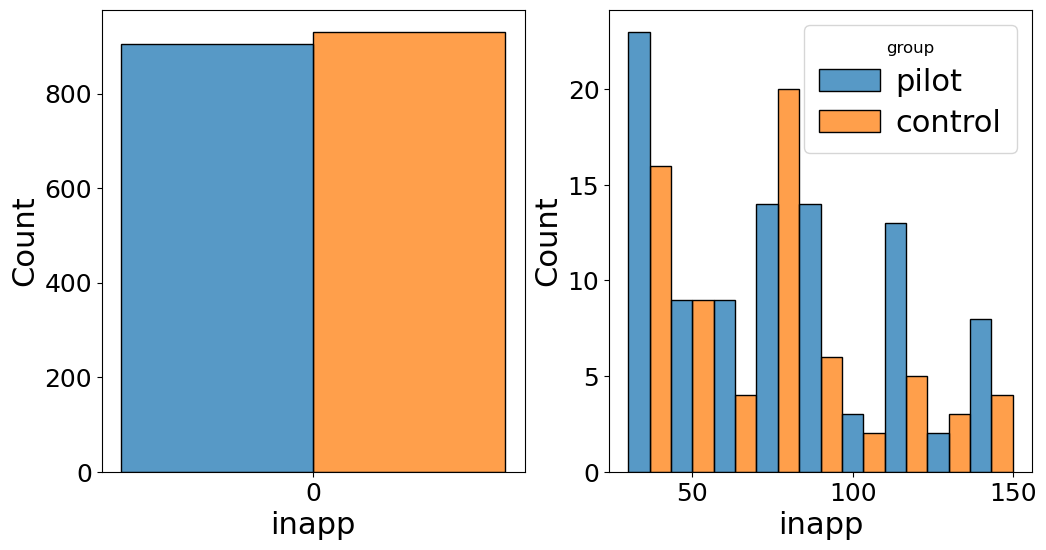

In [18]:
def plot_hist_for_zero_and_nonzero_values(df, feature, group):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    sns.histplot(df[df[feature] == 0], ax=ax1, x=feature, hue=group, multiple='dodge', legend=False)
    ax1.set_xticks([0])
    sns.histplot(df[df[feature] != 0], ax=ax2, x=feature, hue=group, multiple='dodge')

plot_hist_for_zero_and_nonzero_values(df, 'inapp', 'group')

Посчитаем среднее и другие статистики. Проверим статистическую значимость.

In [19]:
df.groupby('group').agg(
    inapp_mean=pd.NamedAgg(column='inapp', aggfunc='mean'),
    inapp_std=pd.NamedAgg(column='inapp', aggfunc='std'),
    inapp_sum=pd.NamedAgg(column='inapp', aggfunc='sum')
)

,inapp_mean,inapp_std,inapp_sum
group,,,
control,5.01,20.253644,5010
pilot,7.36,25.057100,7360


In [21]:
inapp_pilot = df[df['group'] == 'pilot']['inapp'].values
inapp_control = df[df['group'] == 'control']['inapp'].values

stats.ttest_ind(inapp_pilot, inapp_control)

TtestResult(statistic=2.306507565592897, pvalue=0.021184160406364574, df=1998.0)

In [22]:
A = np.std(inapp_control, ddof=1)
B = np.std(inapp_pilot, ddof=1)

((A ** 2 + B ** 2) / 1000) ** .5

1.0188564022316238

pvalue < .05, гипотеза о равенстве средних отвергается на уровне значимости .05

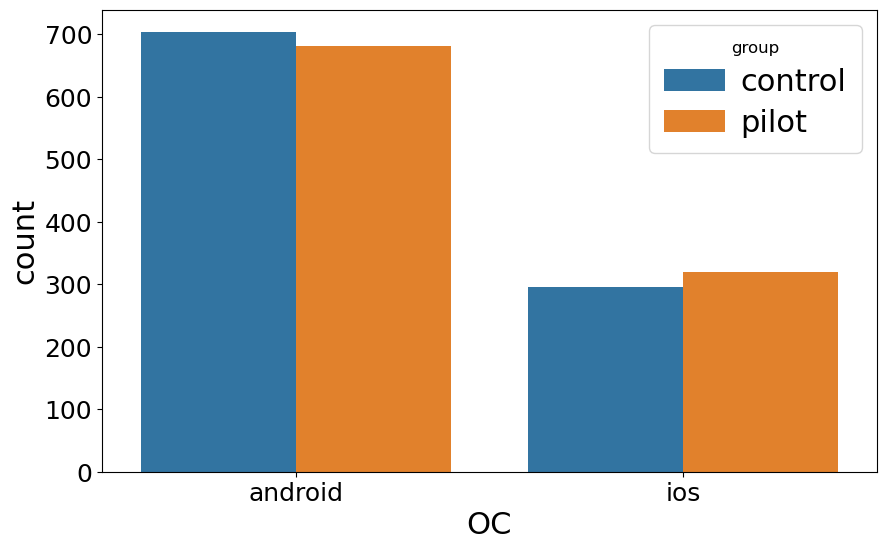

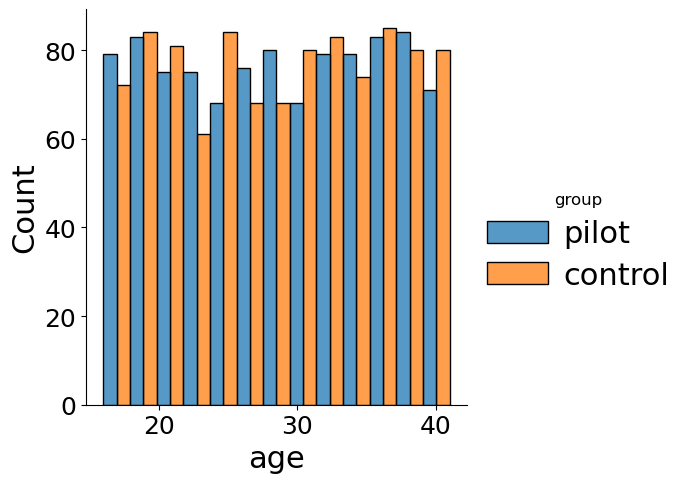

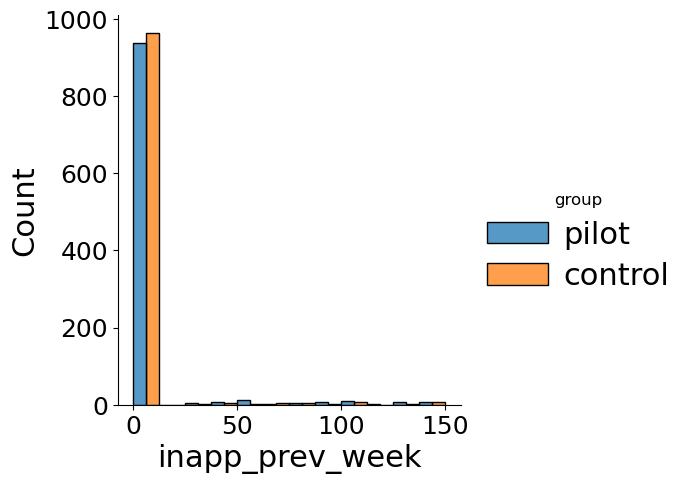

In [25]:
df_agg_ = (
    df.groupby(['group', 'ОС'])[['inapp']].count()
    .rename(columns={'inapp': 'count'}).reset_index()
)
sns.barplot(x='ОС', y='count', hue='group', data=df_agg_)
sns.displot(df, x='age', hue='group', multiple='dodge')
sns.displot(df, x='inapp_prev_week', hue='group', multiple='dodge')

Отличия по ОС очень малы, возраст тоже довольно равномерно распределен. А вот покупки на неделе до пилота,
как и покупки во время пилота, содержат много нулей и в пилотной группе покупок больше.
Давайте сделаем постстратификацию. Стратифицируем данные по наличию покупок до пилота.

In [28]:
def calc_strat_mean(df: pd.DataFrame, strat_column: str, target_name: str, weights: dict):
    """Считам стратифицированное среднее.
    df - датафрейм с целевой метикой и данными для стратификации
    strat_column - названия столбца по которому проводить стратификацию
    target_name - название столбца с целевой переменной
    weights - словарь - {название страты: вес страты}

    return: float, mean_strat
    """
    strat_mean = df.groupby(strat_column)[target_name].mean()
    return (strat_mean * pd.Series(weights)).sum()

In [33]:
df['strat'] = (df['inapp_prev_week'] > 0).astype(int)

strat_weights = df['strat'].value_counts() / df['strat'].count()

df_pilot = df[df['group'] == 'pilot'].copy()
df_control = df[df['group'] == 'control'].copy()

mean_strat_pilot = calc_strat_mean(df_pilot, 'strat', 'inapp', strat_weights)
mean_strat_control = calc_strat_mean(df_control, 'strat', 'inapp', strat_weights)

print('mean strat')
print(f'pilot: {mean_strat_pilot:.3f} control: {mean_strat_control:.3f}')
print(f'delta {mean_strat_pilot - mean_strat_control:.3f}')

print('\nmean simple')
print(f'pilot: {inapp_pilot.mean():.3f} control: {inapp_control.mean():.3f}')
print(f'delta {inapp_pilot.mean() - inapp_control.mean():.3f}')

mean strat
pilot: 6.390 control: 5.861
delta 0.529

mean simple
pilot: 7.360 control: 5.010
delta 2.350


In [36]:
alpha = .05
group_size = df_pilot.shape[0]
n_iter = 2000

def stratified_bootstrap(df: pd.DataFrame, strat_column: str, group_size):
    df_size = len(df_pilot.index)
    indices_list = []
    for group_index in set(df[strat_column].values):
        indices = df[df[strat_column] == group_index].index
        indices_list.append(np.random.choice(indices, int(group_size * len(indices) / df_size)))
    return df.loc[np.concatenate(indices_list)]

list_diff_strat_mean = []
for _ in tqdm(range(n_iter)):
    sample_df_pilot = stratified_bootstrap(df_pilot, 'strat', df_pilot.shape[0])
    sample_df_control = stratified_bootstrap(df_control, 'strat', df_pilot.shape[0])

    mean_strat_sample_pilot = calc_strat_mean(sample_df_pilot, 'strat', 'inapp', strat_weights)
    mean_strat_sample_control = calc_strat_mean(sample_df_control, 'strat', 'inapp', strat_weights)

    list_diff_strat_mean.append(mean_strat_sample_pilot - mean_strat_control)

list_diff_mean = []
for _ in tqdm(range(n_iter)):
    sample_pilot_indexes = np.random.choice(np.arange(group_size), group_size)
    sample_control_indexes = np.random.choice(np.arange(group_size), group_size)
    sample_df_pilot = df_pilot.iloc[sample_pilot_indexes]
    sample_df_control = df_control.iloc[sample_control_indexes]

    list_diff_mean.append(sample_df_pilot['inapp'].mean() - sample_df_control['inapp'].mean())

left_bound_strat_mean = np.quantile(list_diff_strat_mean, alpha / 2)
right_bound_strat_mean = np.quantile(list_diff_strat_mean, 1 - alpha / 2)
left_bound_mean = np.quantile(list_diff_mean, alpha / 2)
right_bound_mean = np.quantile(list_diff_mean, 1 - alpha / 2)

print(f'confidence interval strat mean: ({left_bound_strat_mean:.3f}, {right_bound_strat_mean:.3f})')
print(f'confidence interval mean: ({left_bound_mean:.3f}, {right_bound_mean:.3f})')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

confidence interval strat mean: (-0.444, 1.591)
confidence interval mean: (0.290, 4.310)


 Оценим с помощью теста Стьюдента

In [37]:
def calc_strat_var(df: pd.DataFrame, strat_column: str, target_name: str, weights: dict):
    """Считам стратифицированное среднее.
    df - датафрейм с целевой метикой и данными для стратификации
    strat_column - названия столбца по которому проводить стратификацию
    target_name - название столбца с целевой переменной
    weights - словарь - {название страты: вес страты}

    return: float, var_strat
    """
    strat_var = df.groupby(strat_column)[target_name].var()
    return (strat_var * pd.Series(weights)).sum()

In [42]:
mean_strat_pilot = calc_strat_mean(df_pilot, 'strat', 'inapp', strat_weights)
mean_strat_control = calc_strat_mean(df_control, 'strat', 'inapp', strat_weights)
var_strat_pilot = calc_strat_var(df_pilot, 'strat', 'inapp', strat_weights)
var_strat_control = calc_strat_var(df_control, 'strat', 'inapp', strat_weights)

delta_mean_strat = mean_strat_pilot - mean_strat_control
std_mean_strat = (var_strat_pilot / len(df_pilot) + var_strat_control / len(df_control)) ** .5

confidence_interval_strat = (delta_mean_strat - 1.96 * std_mean_strat, delta_mean_strat + 1.96 * std_mean_strat)
print(f'confidence interval strat mean: ({confidence_interval_strat[0]:.3f}, {confidence_interval_strat[1]:.3f})')

mean_pilot = df_pilot['inapp'].mean()
mean_control = df_control['inapp'].mean()
var_strat_pilot = df_pilot['inapp'].var()
var_strat_control = df_control['inapp'].var()

delta_mean = mean_pilot - mean_control
std_mean = (var_strat_pilot / len(df_pilot) + var_strat_control / len(df_control)) ** .5

confidence_interval = (delta_mean- 1.96 * std_mean, delta_mean + 1.96 * std_mean)
print(f'confidence interval mean: ({confidence_interval[0]:.3f}, {confidence_interval[1]:.3f})')

confidence interval strat mean: (-0.898, 1.957)
confidence interval mean: (0.353, 4.347)


# Обобщающая способность

In [43]:
import statsmodels.api as sm

<Axes: ylabel='Frequency'>

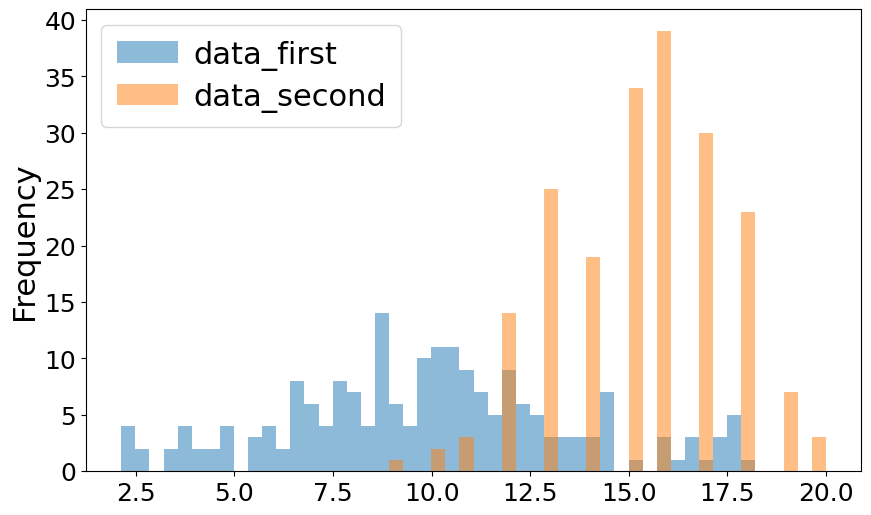

In [45]:
np.random.seed(12)

data_first = np.concatenate((np.random.normal(10, 2, 100), np.random.uniform(2, 18, 100)))
data_second = np.random.binomial(22, .7, 200).astype(float)

pd.DataFrame({'data_first': data_first, 'data_second': data_second}).plot.hist(bins=50, alpha=.5)

[]

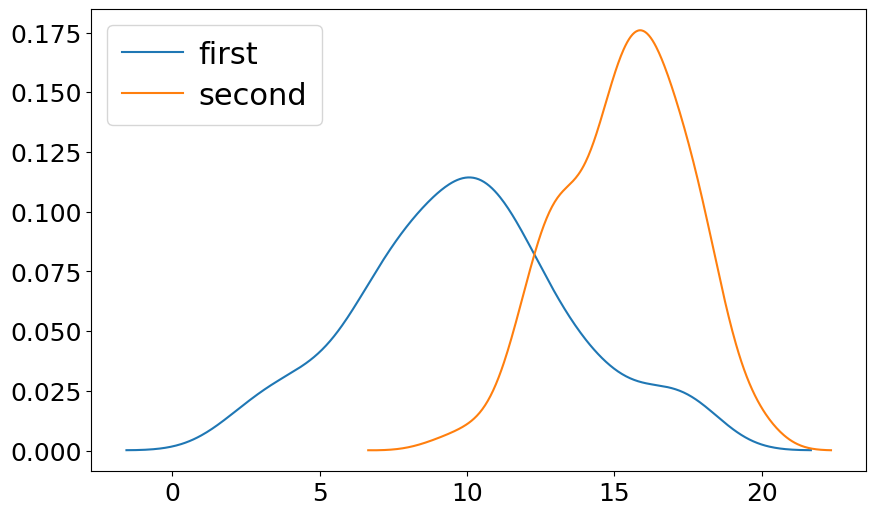

In [52]:
kde_first = sm.nonparametric.KDEUnivariate(data_first)
kde_first.fit()
support_first, density_first = kde_first.support, kde_first.density

kde_second = sm.nonparametric.KDEUnivariate(data_second)
kde_second.fit()
support_second, density_second = kde_second.support, kde_second.density

# calc crossing
density_first_in_support_second = kde_first.evaluate(support_second)
density = [min(density_first_in_support_second[i], density_second[i]) for i in range(len(support_second))]
# dendagarama
plt.plot(support_first, density_first, label='first')
plt.plot(support_second, density_second, label='second')
plt.legend()
plt.plot(loc='upper right')

In [54]:
def calc_integral(coordinates, values):
    integral = 0
    for i in range(len(coordinates) - 1):
        delta_x = coordinates[i + 1] - coordinates[i]
        integral += delta_x * (values[i] + values[i + 1]) / 2
    return integral

cross_integral = calc_integral(support_second, density)
cross_integral

0.3487114154658918